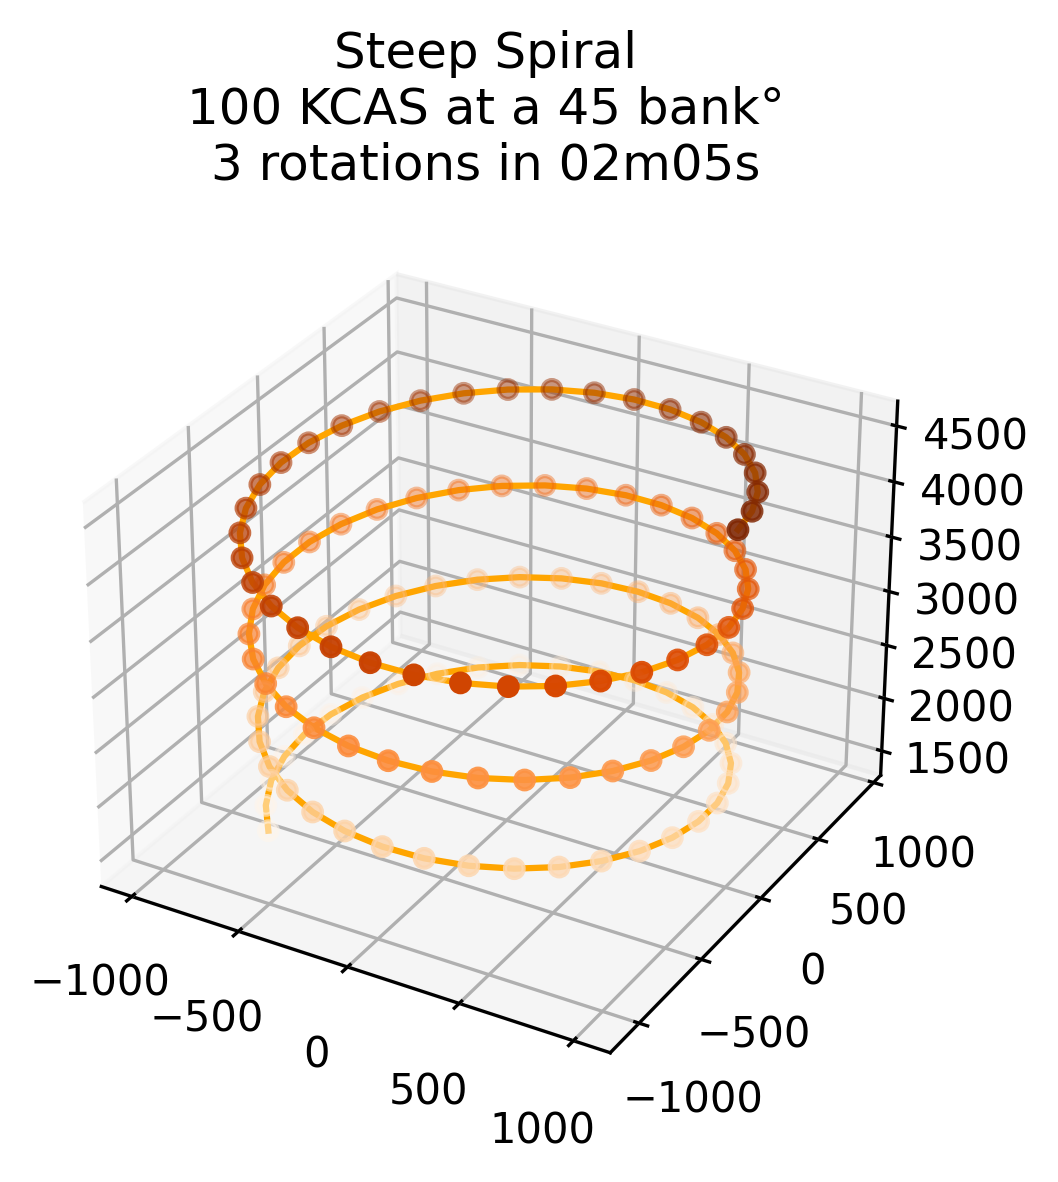

In [20]:
import time

import numpy as np
import matplotlib.pyplot as plt

from n51sw_dataplate import N51SW
from the_bootstrap_approach.equations import *
from the_bootstrap_approach.equations import (
    atmospheric_density as atmospheric_density_func,
)


def tand(deg):
    return np.tan(np.deg2rad(deg))


def arctand(deg):
    return np.arctan(np.deg2rad(deg))


def cosd(deg):
    return np.cos(np.deg2rad(deg))


def sind(deg):
    return np.sin(np.deg2rad(deg))


def radius(
    air_speed, aircraft_bank_angle, flight_path_angle, acceleration_of_gravity=32.174
):
    return (air_speed**2) / (
        acceleration_of_gravity * tand(aircraft_bank_angle) ** cosd(flight_path_angle)
    )


def aircraft_turning_rate(air_speed, radius):
    return np.rad2deg(air_speed / radius)


# "Take an airplane (it does not matter what kind) travelling at 80 KTAS = 135.0
# ft/s, . . ., banked 30 deg. Equation (8.12) then gives radius of curvature R =
# 981.1 ft. And Eq. (8.13) implies the yaw rate is 0.1376 rad/s = 7.884 deg/s"
# (Lowry 242).
turn_radius = radius(135, 30, 0)
turn_rate = aircraft_turning_rate(135, turn_radius)

assert math.isclose(turn_radius, 981.1, abs_tol=10**-1)
assert math.isclose(turn_rate, 7.884, abs_tol=10**-3)

# Adjustable parameters of the simulation.
gross_aircraft_weight = 2500
calibrated_airspeed = 100
bank_angle = 45

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# X, Y, and Z. Starting position, where each coordinate is represented in feet.
positions = [[0, 0, 4500]]
heading = 360
rotations = 0

# While we're above 1,500' AGL. CPL ACS standards.
while positions[-1][2] >= 1500:
    density_altitude = positions[-1][2]

    relative_atmospheric_density = relative_atmospheric_density_alt(
        british_standard_temperature(density_altitude), density_altitude
    )
    atmospheric_density = atmospheric_density_func(relative_atmospheric_density)

    # G multiplied by V^2 (V is TAS in ft/sec) yields parasite drag in pounds of force (lbf).
    g = G(
        atmospheric_density, N51SW.reference_wing_area, N51SW.parasite_drag_coefficient
    )

    # H divided by V^2 yields induced drag in lbf.
    wings_level_h = H(
        gross_aircraft_weight,
        atmospheric_density,
        N51SW.reference_wing_area,
        N51SW.airplane_efficiency_factor,
        N51SW.wing_aspect_ratio,
    )

    # In wings-level, constant-altitude unaccelerated flight to our approximation
    # (no off-axis thrust component), lift L is equal to weight W. When the pilot
    # wants to turn the airplane, he or she banks to some angle Φ, tilting the lift
    # vector towards the desired direction. To maintain altitude, the pilot also
    # applies sufficient backstick, enlarging the vertical component of lift, to
    # balance weight. Because increased lift means increased induced drag, the pilot
    # must also add power if air speed is to be held constant.
    # As mentioned, this additional induced drag while turning leads to the only
    # modification of the wings-level bootstrap approach required to encompass
    # quasi-steady-state maneuvering flight:
    #
    #                    H(0)
    # H ≡ H(0) → H(Φ) ≡ ------                                               (8.22)
    #                   cos² Φ
    #
    # The zero in parentheses denotes a value for unbanked, wings-level flight. For
    # most (not all) intents and purposes, banking to angle Φ is tantamount to
    # increasing gross weight from W to W / cos Φ.
    banked_h = wings_level_h / np.cos(np.deg2rad(bank_angle)) ** 2

    # VT is TAS in ft/sec.
    ktas = tas(calibrated_airspeed, relative_atmospheric_density)
    vt = kn_to_fts(ktas)

    # Power available is zero in a power-off glide.
    pre = power_required(g, banked_h, vt)
    pav = 0
    pxs = pav - pre

    thrust = pav / vt
    drag = pre / vt
    excess_thrust = thrust - drag

    climb_descent_rate = excess_thrust * vt / gross_aircraft_weight
    flight_path_angle = np.rad2deg(np.arcsin(excess_thrust / gross_aircraft_weight))

    turn_radius = radius(vt, bank_angle, flight_path_angle)
    # Set the initial turn radius to maintain a constant radius around (0, 0).
    if positions[-1][0] == 0:
        positions[-1][0] = turn_radius
    turn_rate = aircraft_turning_rate(vt, turn_radius)

    # We know that the Dakota won't turn more than 90 deg/s.
    condition_a = False
    condition_b = False
    if heading < 90:
        condition_a = True

    # Subtracting the turn rate assuming the turn is made counterclockwise
    # (e.g., to the left).
    heading = (heading - turn_rate) % 360

    if heading > 90:
        condition_b = True

    if condition_a is True and condition_b is True:
        rotations += 1

    current_pos = positions[-1]
    positions.append(
        [
            current_pos[0] + (vt * sind(heading)),
            current_pos[1] + (vt * cosd(heading)),
            current_pos[2] + climb_descent_rate,
        ]
    )

positions = np.array(positions)

x = positions[:, 0]
y = positions[:, 1]
z = positions[:, 2]

ax.plot(x, y, z, color="Orange")
ax.scatter(x, y, z, c=z, cmap="Oranges")

fig.set(dpi=300)
plt.title(f"Steep Spiral\n{calibrated_airspeed} KCAS at a {bank_angle} bank°\n{rotations} rotations in {time.strftime('%Mm%Ss', time.gmtime(len(positions)))}")
plt.show()